<a href="https://colab.research.google.com/github/NmadeleiDev/colab/blob/master/clean_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/colab')

In [ ]:
import sys
sys.path.append('/colab/MyDrive/colab/utils')
sys.path.append('/colab/MyDrive/py_notebooks/petstory_model')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import sklearn
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
from os import path
from json import loads

# my files
import db_load
import ram_usage
import importlib
import datetime
importlib.reload(db_load)

DRIVE_ROOT = '/colab/MyDrive'

In [ ]:
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 500)

sns.set_theme()
sns.set(rc={'figure.figsize':(11,6)})

# Load data

In [ ]:
doLoadFromDB = False

if (doLoadFromDB):
    U = db_load.select_data_from_db(
        fields=['install_time', 'event_time', 'touch_time', 'app_id', 'event_name', 'event_value', 'event_revenue', 'region', 
                'appsflyer_id', 'platform', 'device_type', 'wifi', 'operator', 'app_version', 'media_source'],
        task_id=[27,28],
        date_start='2021-01-16',
        date_end='2021-03-18')
else:
    U = pd.read_csv(DRIVE_ROOT +  '/colab/raw_data/dominos_2021_01_15-2021_03_16.csv',
                    parse_dates=['event_time', 'install_time', 'touch_time']
                   ).convert_dtypes()

In [ ]:
doSaveToFile = False

if (doSaveToFile):
    U.to_csv(DRIVE_ROOT +  '/colab/raw_data/dominos_2021_01_15-2021_03_18.csv')

In [ ]:
def clear_event_names(event_names):
    return event_names.str.replace('^(AnalyticsEventType\.af_|AnalyticsEventType\.|af_)', '', regex=True)

U['event_name'] = clear_event_names(U['event_name'])

In [ ]:
U.head()

,Unnamed: 0,install_time,event_time,touch_time,app_id,event_name,event_value,event_revenue,region,appsflyer_id,platform,device_type,wifi,operator,app_version
0,0,2021-01-16 00:01:11,2021-01-16 00:01:43,2021-01-15 23:59:56,com.boloid.dominos,restaurant_selected,"{""locationCode"":""90521""}",0.000000,EU,1610744469166-5756005509657797859,android,samsung-SM-A015F,0,Beeline,4.8.3
1,1,2021-01-16 00:01:11,2021-01-16 00:01:16,2021-01-15 23:59:56,com.boloid.dominos,first_launch,{},0.000000,EU,1610744469166-5756005509657797859,android,samsung-SM-A015F,0,Beeline,4.8.3
2,2,2021-01-16 00:01:11,2021-01-16 00:01:14,2021-01-15 23:59:56,com.boloid.dominos,restaurant_selected,"{""locationCode"":""90401""}",0.000000,EU,1610744469166-5756005509657797859,android,samsung-SM-A015F,0,Beeline,4.8.3
3,3,2021-01-16 00:01:11,2021-01-16 00:01:12,2021-01-15 23:59:56,com.boloid.dominos,session_start,{},0.000000,EU,1610744469166-5756005509657797859,android,samsung-SM-A015F,0,Beeline,4.8.3
4,4,2021-01-16 00:01:55,2021-01-16 00:01:58,2021-01-15 23:59:26,com.boloid.dominos,first_launch,{},0.000000,EU,1610744518238-3120122628163556746,android,HONOR-JSN-L21,0,Tele2,4.8.4


In [ ]:
U[U['install_time'] > pd.to_datetime('2021-02-15')].shape
# U.shape

(756602, 15)

In [ ]:
def get_time_to_purchases(df, num_purchases=5):
    transactions = df[df['event_name'] == 'transaction']
    install_time = df['install_time'].iloc[0]
    times = transactions['event_time'].apply(lambda x: x - install_time if not pd.isna(x) else pd.NaT)
    if (times.shape[0] >= num_purchases):
        return pd.Series(times.iloc[:num_purchases].values)
    return pd.Series(times.values)

pur_times = U[U['install_time'] > pd.to_datetime('2021-02-16')].iloc[:].groupby('appsflyer_id').apply(get_time_to_purchases)

In [ ]:
pur_times.dropna() #.unstack(level=-1)

appsflyer_id                        
1450106542000-2679353              0   15 days 21:36:48
                                   1   14 days 23:15:40
1457199650000-7069157              0   12 days 23:06:20
                                   1    0 days 00:06:56
1458297781000-3400882              0    0 days 13:44:42
                                             ...       
1615839239782-3027286              1    1 days 11:33:37
1615839331180-1416063065856151160  0   24 days 00:17:07
                                   1   13 days 15:54:17
                                   2    9 days 22:51:04
1615840180244-9520106              0    0 days 00:06:59
Length: 18732, dtype: timedelta64[ns]

In [ ]:
lt_to_ltv = (U[['appsflyer_id', 'event_name', 'event_time', 'event_revenue', 'media_source', 'wifi']].groupby(by='appsflyer_id')
    .apply(lambda data: pd.Series({'ltv': data[data['event_name'] == 'transaction']['event_revenue'].sum(),
                         'lt_seconds': (data['event_time'].max() - data['event_time'].min()).total_seconds(),
                         'media_source': data['media_source'].iloc[0],
                         'wifi': data[data['event_name'] == 'transaction']['wifi'].mean() >= 0.5})))

In [ ]:
lt_to_ltv['wifi'].value_counts()

False    82196
True     14538
Name: wifi, dtype: int64

In [ ]:
lt_to_ltv['lt_hours'] = lt_to_ltv['lt_seconds'] // 3600

sns.lmplot(x='lt_hours', y='ltv', data=lt_to_ltv, col='media_source', col_wrap=3, hue='wifi', line_kws={"color": "red"});

In [ ]:
(lt_to_ltv['lt_hours'] // 24).mean()

11.316124630429838

In [ ]:
# U[U['appsflyer_id'] == '1613663791158-5511852221383606985'].sort_values(['event_time']) какой то тестовый хуй

### Enrich data

In [ ]:
def try_loads(input):
    try:
        return loads(input)
    except Exception as e:
        return {}

loaded = U['event_value'].str.lower().apply(try_loads)

In [ ]:
U.shape

(1572720, 15)

In [ ]:
U['location_code'] = loaded.apply(lambda x: x['locationcode'] if 'locationcode' in x.keys() else np.nan)
U['upsell_code'] = loaded.apply(lambda x: x['upsellcode'] if 'upsellcode' in x.keys() else np.nan)

# Group events to metrics

In [ ]:
class Grouper():
    def __init__(self, df, mode='train', slice_before_event=None):
        self.mode = mode

        self.common_events = df['event_name'].value_counts().index[:10]
        self.consts = {
            'day_in_seconds': 86400,
            'half_day_seconds': 86400 / 2,
            'three_days_seconds': 86400 * 3,
        }

        self.empty_val = lambda: {}
        self.log_bias = 0.001

        self.slice_before_event = slice_before_event

    def slice_life_part(self, df):
        copy = df.copy()

        # если меньше одного дня - всю жизнь
        # иначе - наибольший промежуток между первым и вторым днем
        # для трени вовзращать кол-во секунд по которому обрезал - это ведь и есть жизнь для прода!
        # ! на проде считать lt не по последнему событию, а по настоящее время!!

        install_time = df['install_time'].iloc[0]
        activity_period = (df['event_time'].max() - install_time).total_seconds()

        if (activity_period < self.consts['day_in_seconds']):
            return copy, np.random.randint(activity_period, self.consts['day_in_seconds'])
        elif (activity_period < self.consts['three_days_seconds']):
            slice_second = np.random.randint(self.consts['day_in_seconds'], activity_period)
            return copy[(copy['event_time'] - install_time) < pd.to_timedelta(slice_second, unit='seconds')], slice_second
        else:
            slice_second = np.random.randint(self.consts['day_in_seconds'], self.consts['three_days_seconds'])
            return copy[(copy['event_time'] - install_time) < pd.to_timedelta(slice_second, unit='seconds')], slice_second


    def seconds_to_sin_cos(self, in_seconds, prefix='time'):
        if (np.isnan(in_seconds)):
            return {'{}_sin'.format(prefix): np.nan, '{}_cos'.format(prefix): np.nan}

        rads = (in_seconds * 2 * np.pi) / self.consts['day_in_seconds']
        return {'{}_sin'.format(prefix): np.sin(rads), '{}_cos'.format(prefix): np.cos(rads)}

    def group_period_dependent_metrics(self, df, lt_interval, suffix='Y'):
        df['event_time'] = pd.to_datetime(df.pop('event_time'), errors='coerce')

        event_dates = df['event_time'].dt.date
        install_time = df['install_time'].iloc[0]
        last_event_time = df['event_time'].max()
        first_event_time = df['event_time'].min()
        lt_days = max(lt_interval.days, 0)
        active_days = len(event_dates.unique())
        events_per_day = df.shape[0] / (lt_days if lt_days > 0 else 1)
        events_per_active = df.shape[0] / (active_days if active_days > 0 else 1)
        transactions = df[df['event_name'] == 'transaction']

        if (transactions.empty is False):
            revenue_sum = transactions['event_revenue'].sum()
            num_transactions = transactions.shape[0]
            transactions_mean = transactions['event_revenue'].mean()
            transactions_std = transactions['event_revenue'].std()
        else:
            revenue_sum = 0
            num_transactions = 0
            transactions_std = 0
            transactions_mean = 0

        return {
            'seconds_to_first_event_log_{}'.format(suffix): np.log(max((first_event_time - install_time).total_seconds(), self.log_bias)),
            'seconds_from_last_event_log_{}'.format(suffix): np.log(max((install_time + lt_interval - last_event_time).total_seconds(), self.log_bias)),
            'lt_seconds_{}'.format(suffix): max(lt_interval.total_seconds(), 0),
            'lt_seconds_log_{}'.format(suffix): np.log(max(lt_interval.total_seconds(), 0) + self.log_bias),
            'lt_days_{}'.format(suffix): lt_days,
            'active_days_{}'.format(suffix): active_days,
            'events_per_day_{}'.format(suffix): events_per_day,
            'events_per_day_log_{}'.format(suffix): np.log(events_per_day if events_per_day > 0 else self.log_bias),
            'events_per_active_day_{}'.format(suffix): events_per_active,
            'events_per_active_to_events_per_day_{}'.format(suffix): events_per_day / (events_per_active if events_per_active > 0 else 1),
            'revenue_sum_{}'.format(suffix): revenue_sum,
            'revenue_sum_log_{}'.format(suffix): np.log(max(revenue_sum, 0) + self.log_bias),
            'num_transactions_{}'.format(suffix): num_transactions,
            'transactions_std_log_{}'.format(suffix): np.log(max(transactions_std, 0) + self.log_bias),
            'transactions_mean_{}'.format(suffix): transactions_mean,
        }

    def group_event_counts(self, df):
        return df['event_name'].value_counts().reindex(index=self.common_events, fill_value=0).to_dict()

    def group_period_independent_metrics(self, df):
        install_time = df['install_time'].iloc[0]
        touch_time = df['touch_time'].iloc[0]

        return {
            'appsflyer_id': df['appsflyer_id'].iloc[0],
            'app_id': df['app_id'].iloc[0],
            'region': df['region'].iloc[0],
            'platform': df['platform'].iloc[0],
            'install_time': str(install_time),
            **self.seconds_to_sin_cos(install_time.timestamp() if pd.isnull(install_time) is False else np.nan, prefix='install_time'),
            **self.seconds_to_sin_cos(touch_time.timestamp() if pd.isnull(touch_time) is False else np.nan, prefix='touch_time'),
        }
        
    # data-specific aggregations
    def group_special_metrics(self, df, suffix='Y'):
        coupons_added = df[df['event_name'] == 'add_coupon']['event_name'].count()
        return {
            'most_common_location_{}'.format(suffix): self.most_common_rest(df),
            'most_common_upsell_code_{}'.format(suffix): self.most_common_upsell_code(df),
            'coupons_added_{}'.format(suffix): coupons_added,
            'coupons_added_log_{}'.format(suffix): np.log(coupons_added if coupons_added > 0 else self.log_bias)
        }

    def most_common_upsell_code(self, df):
        vals = df['upsell_code'].dropna()
        return vals.value_counts().index[0] if vals.empty is False else np.nan

    def most_common_rest(self, df):
        vals = df['location_code'].dropna()
        return vals.value_counts().index[0] if vals.empty is False else np.nan

    def transform(self, df):
        if (df['event_name'].count() < 10):
            return self.empty_val()
        
        if (self.mode == 'train'):
            train_data, lt_seconds = self.slice_life_part(df)
            if (train_data.empty):
                return self.empty_val()
            
            return {
                **self.group_period_independent_metrics(train_data),
                **self.group_period_dependent_metrics(train_data, pd.to_timedelta(lt_seconds, unit='seconds'), suffix='X'),
                **self.group_special_metrics(train_data, suffix='X'),
                **self.group_event_counts(train_data),
                **self.group_period_dependent_metrics(df, df['event_time'].max() - df['install_time'].iloc[0], suffix='Y'),
                **self.group_special_metrics(df, suffix='Y'),
            }
        else:
            df_copy = df.copy()
            return {
                **self.group_period_independent_metrics(df_copy),
                **self.group_event_counts(df_copy),
                **self.group_period_dependent_metrics(df_copy, df_copy['event_time'].max() - datetime.datetime.now(), suffix='Y'),
                **self.group_special_metrics(df_copy, suffix='Y'),
            }

    def generate_group_func(self):
        return self.transform
    


In [ ]:
grouper = Grouper(U)

In [ ]:
grouped = U.iloc[:].groupby(by='appsflyer_id').apply(grouper.generate_group_func())

In [ ]:
D = pd.DataFrame(list(grouped[grouped.apply(lambda x: bool(x))].values))

In [ ]:
np.min(np.exp(D['seconds_from_last_event_log_X']) / 3600)

0.0002777777777777778

In [ ]:
D['lt_days_X'].mean()

0.9452258614874918

In [ ]:
# D[(D['num_transactions_Y'] > 0) & (D['revenue_sum_Y'] == 0)]

In [ ]:
# pd.to_datetime(D['install_time']).dt.date.hist()

In [ ]:
D.set_index('appsflyer_id').to_csv(DRIVE_ROOT +  '/colab/prepared_data/dominos_v3_2021_01_15-2021_03_18.csv')

# Explore grouped data

In [ ]:
concatParts = False
forceReloadD = False

if ('D' not in globals() or forceReloadD):
    if (concatParts):
        p1 = pd.read_csv(DRIVE_ROOT +  '/colab/prepared_data/dominos_2021_01_15-2021_03_18.csv')
        p2 = pd.read_csv(DRIVE_ROOT +  '/colab/prepared_data/dominos_part2_2021_01_15-2021_03_18.csv')
        p2['appsflyer_id'] = p2['appsflyer_id'].apply(lambda x: x + '_p2')
        D = pd.concat([p1, p2])
    else:
        D = pd.read_csv(DRIVE_ROOT +  '/colab/prepared_data/dominos_v3_2021_01_15-2021_03_18.csv')

In [ ]:
D['events_per_day_Y'].quantile(q=0.99)

44.0

In [ ]:
D[D['events_per_day_X'] == 234]

,appsflyer_id,app_id,region,platform,install_time,install_time_sin,install_time_cos,touch_time_sin,touch_time_cos,seconds_to_first_event_log_X,seconds_from_last_event_log_X,lt_seconds_X,lt_seconds_log_X,lt_days_X,active_days_X,events_per_day_X,events_per_day_log_X,events_per_active_day_X,events_per_active_to_events_per_day_X,revenue_sum_X,revenue_sum_log_X,num_transactions_X,transactions_std_log_X,transactions_mean_X,most_common_location_X,most_common_upsell_code_X,coupons_added_X,coupons_added_log_X,restaurant_selected,session_start,add_to_cart,first_launch,confirm_order,add_coupon,purchase,update_product,transaction,remove_product,seconds_to_first_event_log_Y,seconds_from_last_event_log_Y,lt_seconds_Y,lt_seconds_log_Y,lt_days_Y,active_days_Y,events_per_day_Y,events_per_day_log_Y,events_per_active_day_Y,events_per_active_to_events_per_day_Y,revenue_sum_Y,revenue_sum_log_Y,num_transactions_Y,transactions_std_log_Y,transactions_mean_Y,most_common_location_Y,most_common_upsell_code_Y,coupons_added_Y,coupons_added_log_Y


In [ ]:
def drop_extreme_values(df):
    # тестовые юзеры
    mask_test_users = np.logical_or(df['events_per_day_Y'] <= df['events_per_day_Y'].quantile(q=0.99), df['num_transactions_Y'] > 0)
    mask_invalid_revenue = np.logical_or(df['revenue_sum_Y'] == 0, df['revenue_sum_Y'] >= 500)
    return df.where(mask_test_users).where(mask_invalid_revenue).dropna(how='all')

In [ ]:
drop_extreme_values(D).describe()

,install_time_sin,install_time_cos,touch_time_sin,touch_time_cos,seconds_to_first_event_log_X,seconds_from_last_event_log_X,lt_seconds_X,lt_seconds_log_X,lt_days_X,active_days_X,events_per_day_X,events_per_day_log_X,events_per_active_day_X,events_per_active_to_events_per_day_X,revenue_sum_X,revenue_sum_log_X,num_transactions_X,transactions_std_log_X,transactions_mean_X,coupons_added_X,coupons_added_log_X,restaurant_selected,session_start,add_to_cart,first_launch,confirm_order,add_coupon,purchase,update_product,transaction,remove_product,seconds_to_first_event_log_Y,seconds_from_last_event_log_Y,lt_seconds_Y,lt_seconds_log_Y,lt_days_Y,active_days_Y,events_per_day_Y,events_per_day_log_Y,events_per_active_day_Y,events_per_active_to_events_per_day_Y,revenue_sum_Y,revenue_sum_log_Y,num_transactions_Y,transactions_std_log_Y,transactions_mean_Y,coupons_added_Y,coupons_added_log_Y
count,49364.000000,49364.000000,48634.000000,48634.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,25412.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,49364.000000,27152.000000,49364.000000,49364.000000,49364.000000
mean,-0.512858,-0.112545,-0.244046,-0.134717,-0.757206,11.124877,125585.318390,11.459344,0.946013,1.205150,14.906916,2.493683,15.442041,0.996100,634.599309,0.124194,0.528442,-6.560942,608.334666,1.001175,-2.893062,4.753099,2.516956,3.124990,0.986569,1.198262,1.001175,0.746536,0.722206,0.528442,0.524957,-0.757206,-6.907755,1713877.639920,11.923893,19.530913,2.857204,7.882924,1.093826,11.566278,0.545761,943.375812,1.341664,0.815716,-4.311146,702.265479,1.480087,-2.154198
std,0.519063,0.674462,0.649178,0.707728,2.884628,1.177981,73455.614956,0.910948,0.817098,0.444051,9.896798,0.682820,9.326294,0.397483,891.522257,6.957435,0.546096,2.021786,826.003874,1.469955,3.663355,3.909472,1.643073,3.349802,0.116685,1.192463,1.469955,0.869695,1.909419,0.546096,1.318020,2.884628,0.000000,1770366.183905,3.673966,20.362384,2.268115,9.840962,1.518903,7.365704,0.525653,1301.384912,6.952312,1.021759,5.007229,836.455841,2.131590,3.649259
min,-1.000000,-1.000000,-1.000000,-1.000000,-6.907755,0.000000,93.000000,4.532610,0.000000,1.000000,0.500000,-0.693147,1.000000,0.500000,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.907755,-6.907755,1.000000,0.001000,0.000000,1.000000,0.120482,-2.116256,1.333333,0.022727,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755
25%,-0.938669,-0.795319,-0.860316,-0.832559,0.000000,10.634569,63689.750000,11.061779,0.000000,1.000000,8.500000,2.140066,10.000000,1.000000,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.907755,2995.000000,8.004700,0.000000,1.000000,0.763636,-0.269664,6.444444,0.109375,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755
50%,-0.718278,-0.139281,-0.375213,-0.249711,0.000000,11.407026,120485.500000,11.699285,1.000000,1.000000,13.000000,2.564949,14.000000,1.000000,503.000000,6.220592,1.000000,-6.907755,500.340000,1.000000,0.000000,4.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-6.907755,1375838.000000,14.134574,15.000000,2.000000,2.000000,0.693147,10.000000,0.230769,699.000000,6.549652,1.000000,-6.907755,647.249524,1.000000,0.000000
75%,-0.212444,0.490967,0.273470,0.531429,0.693147,11.977590,188871.250000,12.148821,2.000000,1.000000,19.000000,2.944439,19.000000,1.000000,1006.200000,6.913937,1.000000,-6.90

In [ ]:
D.shape

(50407, 57)

In [ ]:
# D.hist(bins=30, figsize=(20,25));

In [ ]:
D['lt_seconds_X'].mean() / (3600 * 24)

1.4530106422149627

In [ ]:
# D[D['revenue_sum_Y'] > D['revenue_sum_Y'].quantile(q=0.97)].hist(bins=30, figsize=(20,25));

### Add class

11 - купил и купит

10 - купил и не купит

01 - не купил и купит

00 - не купил и не купит

In [ ]:
metric_to_split_classes = 'revenue_sum'

def get_user_class(df):
    if (df['{}_X'.format(metric_to_split_classes)] == 0 and df['{}_Y'.format(metric_to_split_classes)] == 0):
        return [0, 0]
    elif (df['{}_X'.format(metric_to_split_classes)] == 0 and df['{}_Y'.format(metric_to_split_classes)] > 0):
        return [0, 1]
    elif (df['{}_X'.format(metric_to_split_classes)] > 0 and df['{}_Y'.format(metric_to_split_classes)] == df['{}_X'.format(metric_to_split_classes)]):
        return [1, 0]
    elif (df['{}_X'.format(metric_to_split_classes)] > 0 and df['{}_Y'.format(metric_to_split_classes)] > df['{}_X'.format(metric_to_split_classes)]):
        return [1, 1]

D[['revenue_current', 'revenue_future']] = np.array(D[['{}_X'.format(metric_to_split_classes), '{}_Y'.format(metric_to_split_classes)]].apply(get_user_class, axis=1).to_list())

In [ ]:
D['class'] = (D['revenue_current'] * 10 + D['revenue_future']).apply(lambda x: '{:02.0f}'.format(x))

In [ ]:
D.set_index(['revenue_current', 'revenue_future', 'appsflyer_id'], drop=False, inplace=True)

In [ ]:
D.sort_index(inplace=True)

In [ ]:
D[['num_transactions_X', 'num_transactions_Y', 'class']]['class'].value_counts()

10    20728
00    20657
11     4956
01     4066
Name: class, dtype: int64

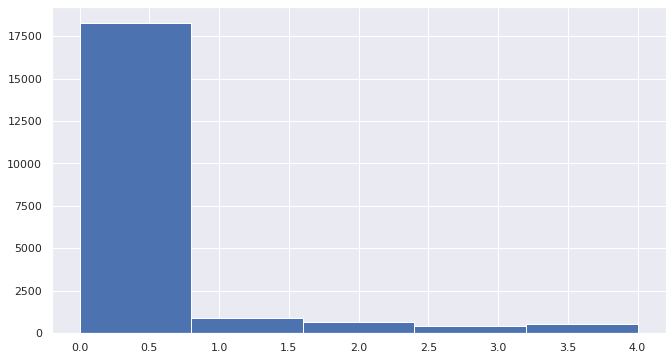

In [ ]:
D[D['lt_days_Y'] < 5]['lt_days_Y'].hist(bins=5);

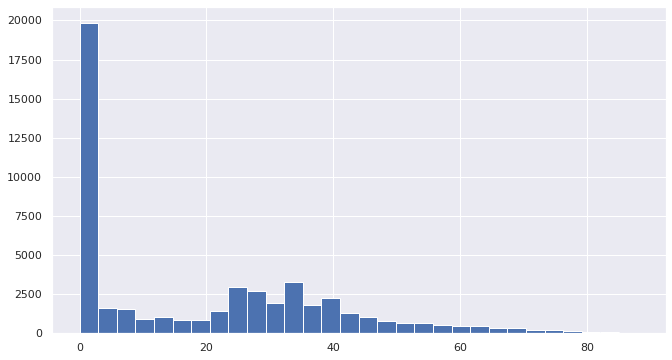

In [ ]:
D['lt_days_Y'].hist(bins=30);

Text(0.5, 1.0, 'Распредление целевого LTV по всем пользователям')

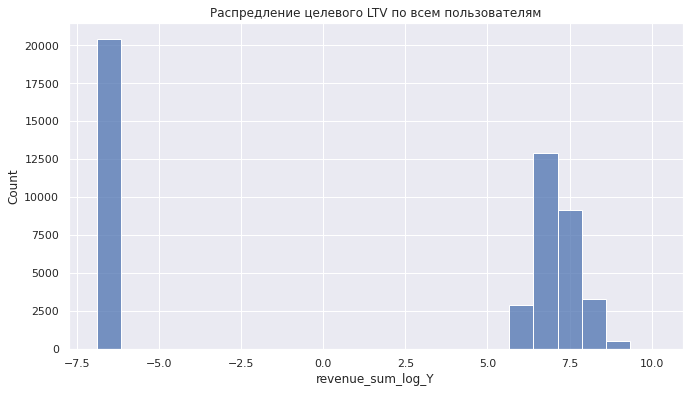

In [ ]:
sns.histplot(data=drop_extreme_values(D), x='revenue_sum_log_Y').set_title('Распредление целевого LTV по всем пользователям')

In [ ]:
D.shape

(50407, 60)

In [ ]:
D[(D['revenue_sum_X'] == 0) & (D['num_transactions_X'] > 0)]

appsflyer_id  ... class
revenue_current revenue_future appsflyer_id                                  ...      
0               0              1584770471000-6596161  1584770471000-6596161  ...    00
                               1612975247624-0416669  1612975247624-0416669  ...    00
                               1613323003722-6856691  1613323003722-6856691  ...    00

[3 rows x 58 columns]

# Train models

### Prepare data

Тут нужно обучить два классификатора и два регрессора: классификатор на купит/не купит для тех, кто еще не покупал, и на допкупит/не докупит. И два регрессора revenue на положительные ответы по предыдущему.


Читать и перечитывать статью!!

http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines

In [ ]:
D['class0_target'] = (D['revenue_sum_Y'] > 0).astype(int)
D['class1_target'] = (D['revenue_sum_Y'] > D['revenue_sum_X']).astype(int)
D['regr0_target'] = D['revenue_sum_Y']
D['regr1_target'] = D['revenue_sum_Y']

In [ ]:
TARGET_COL_NAME = 'revenue_sum_Y'

num_cols_x = ['install_time_sin', 'install_time_cos', 'touch_time_sin', 'touch_time_cos', 
              'seconds_to_first_event_log_X', 'lt_seconds_log_X', 
              'lt_days_X', 
              'active_days_X',
       'events_per_day_log_X', 'events_per_active_day_X',
       'events_per_active_to_events_per_day_X', 
       'seconds_from_last_event_log_X',
    #    'revenue_sum_X',
       'revenue_sum_log_X', 
       'num_transactions_X', 'transactions_std_log_X',
       'transactions_mean_X', 
    #    'coupons_added_X', 
       'coupons_added_log_X',
       'restaurant_selected', 'session_start', 'add_to_cart', 'first_launch',
       'confirm_order', 'add_coupon', 'purchase', 'update_product',
    #    'transaction', 
       'remove_product']

str_cols_x = ['region', 'platform', 'most_common_location_X', 'most_common_upsell_code_X']

x_cols = num_cols_x + str_cols_x
len(x_cols)

30

In [ ]:
def fillna_dataset(ds):
    copy = ds.copy()

    fill_with_mean = []

    steps_seconds_to_Y = copy[[x for x in list(copy.columns) if x.endswith('_seconds_to_first_event_Y')]].apply(
        lambda col: col.where(pd.isna(col) == False, copy['lt_seconds_Y'])
    )

    steps_seconds_to_X = copy[[x for x in list(copy.columns) if x.endswith('_seconds_to_first_event_X')]].apply(
        lambda col: col.where(pd.isna(col) == False, copy['lt_seconds_X'])
    )

    fill_to_zeros_cols = [x for x in list(num_cols_x) if x not in corrector.steps_seconds_to]
    copy[fill_to_zeros_cols] = copy[fill_to_zeros_cols].replace([np.nan, np.inf, -np.inf], 0)

    copy.update(steps_seconds_to_Y)
    copy.update(steps_seconds_to_X)
    
    return copy

In [ ]:
class DfSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attr_names):
        self.attr_names = attr_names
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return x[self.attr_names].values
    
    def inverse_transform(self, x):
        return x[self.attr_names].values
    
class EraseNonStrings(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        apply = lambda value: value if isinstance(value, str) else ''
        vfunc = np.vectorize(apply)
        return vfunc(x)
    
    def inverse_transform(self, x):
        return x
    
    
def create_preprocessing_pipeline(num_attrs=None, cat_attrs=None):
    if ((num_attrs is None) and (cat_attrs is None)):
        return None
    
    num_pipeline = Pipeline([
        ('selector', DfSelector(num_attrs)),
        ('impute', SimpleImputer(missing_values=np.nan, fill_value=0, strategy='constant')),
        # ('scaler1', preprocessing.StandardScaler()),
        ('scaler2', preprocessing.MinMaxScaler()),
    ])
    cat_pipeline = Pipeline([
        ('selector', DfSelector(cat_attrs)),
        ('stringTransform', EraseNonStrings()),
        ('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'))
    ])
    full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipe', num_pipeline),
        ('cat_pipe', cat_pipeline)
    ])
    
    return full_pipeline

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def split_dataset(df, split_cols, test_size=0.2):
    split_top_ceil_val = 5
    split_bottom_ceil_val = 0
    split_val = 400

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    splits = split.split(df, df[split_cols])
    
    for train_index, test_index in splits:
        test_data = df.iloc[test_index]
        train_data = df.iloc[train_index]
        
    return train_data, test_data

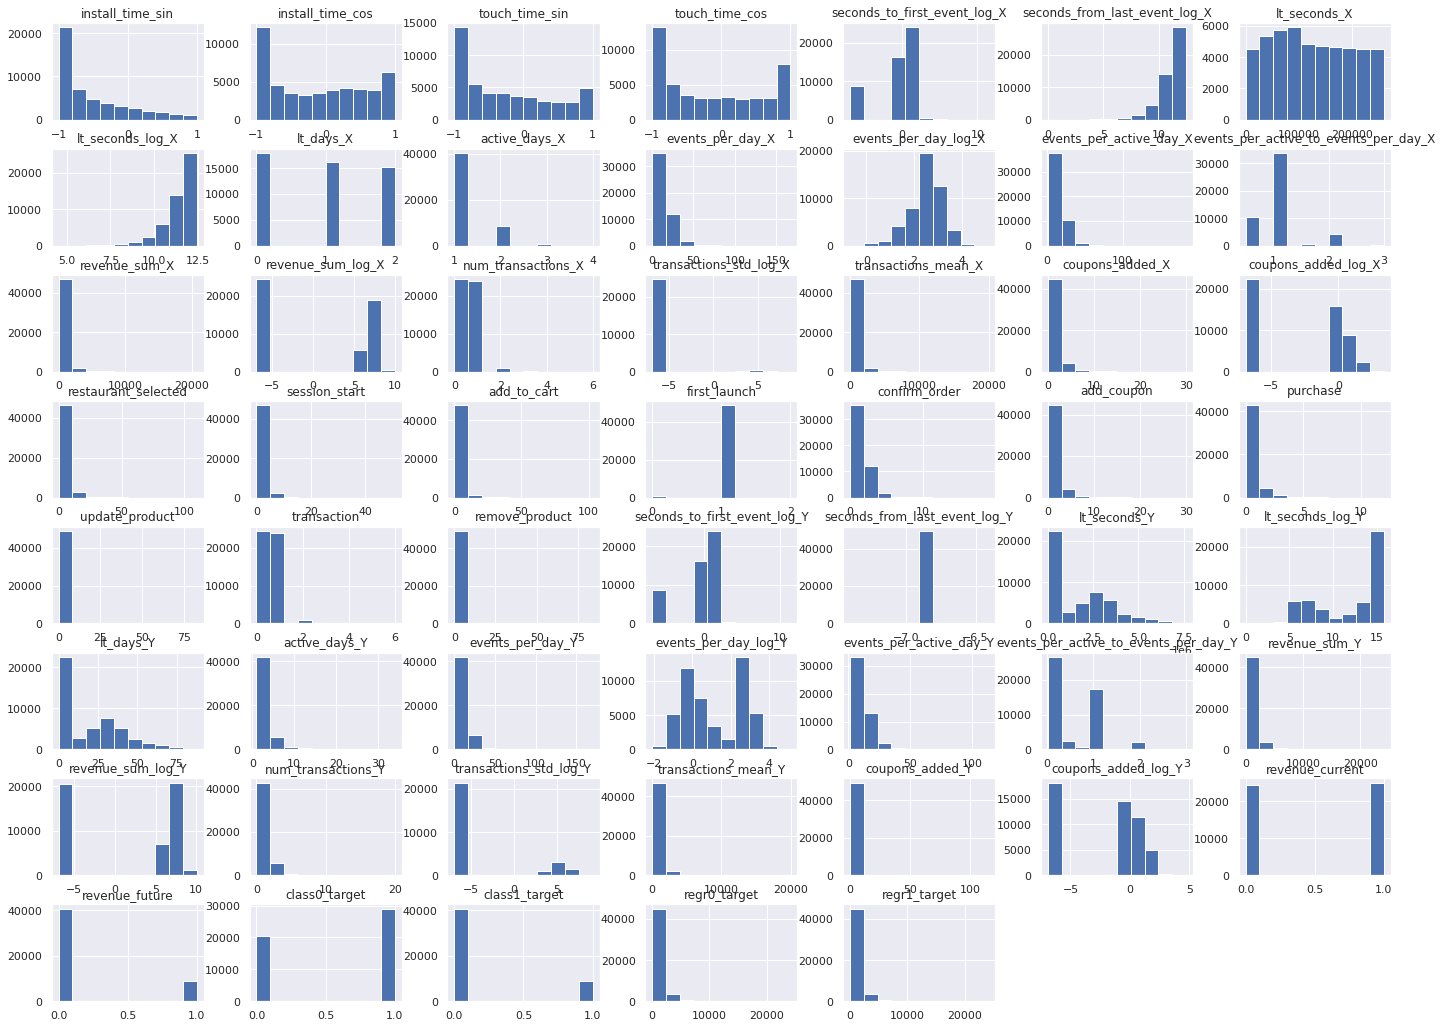

In [ ]:
drop_extreme_values(D).hist(figsize=(24, 18));

In [ ]:
doCreateEvalSet = True

D['revenue_class'] = pd.qcut(D['revenue_sum_Y'], 5, duplicates='drop').factorize()[0]
if (doCreateEvalSet):
    train_data, test_data = split_dataset(drop_extreme_values(D).copy(), ['class', 'revenue_class'], test_size=0.2)
    train_data, eval_data = split_dataset(train_data, ['revenue_class'], test_size=0.2)
else:
    train_data, test_data = split_dataset(drop_extreme_values(D).copy(), ['class', 'revenue_class'], test_size=0.2)
    eval_data = None
D.pop('revenue_class');

In [ ]:
eval_data['class'].value_counts()

10    3292
00    3243
11     740
01     624
Name: class, dtype: int64

In [ ]:
from joblib import dump

In [ ]:
full_pipeline = create_preprocessing_pipeline(num_attrs=num_cols_x, cat_attrs=str_cols_x)
full_pipeline.fit(train_data)

doSavePipeline = True
if (doSavePipeline):
    dump(full_pipeline, path.join(DRIVE_ROOT, 'colab/pipelines/dominos_pipeline.joblib'))

train_set = {
    'U': train_data,
    'U_X': np.array(full_pipeline.transform(train_data[x_cols]).todense()),
    'U_Y': train_data[TARGET_COL_NAME].values,

    'class_1': {
        'X': np.array(full_pipeline.transform(train_data.loc[1][x_cols]).todense()),
        'Y': (train_data.loc[1].index.get_level_values(0) == 1).astype(int),
        'R': train_data.loc[1],
    },
    'class_0': {
        'X': np.array(full_pipeline.transform(train_data.loc[0][x_cols]).todense()),
        'Y': (train_data.loc[0].index.get_level_values(0) == 1).astype(int),
        'R': train_data.loc[0],
    },
    'regr_1': {
        'X': np.array(full_pipeline.transform(train_data.loc[1, 1][x_cols]).todense()),
        'Y': (train_data.loc[1, 1][TARGET_COL_NAME]).to_numpy(),
        'R': train_data.loc[1, 1],
    },
    'regr_0': {
        'X': np.array(full_pipeline.transform(train_data.loc[0, 1][x_cols]).todense()),
        'Y': (train_data.loc[0, 1][TARGET_COL_NAME]).to_numpy(),
        'R': train_data.loc[0, 1],
    }
}

test_set = {
    'U': test_data,
    'U_X': np.array(full_pipeline.transform(test_data[x_cols]).todense()),
    'U_Y': test_data[TARGET_COL_NAME].values,

    'class_1': {
        'X': np.array(full_pipeline.transform(test_data.loc[1][x_cols]).todense()),
        'Y': (test_data.loc[1].index.get_level_values(0) == 1).astype(int),
        'R': test_data.loc[1],
    },
    'class_0': {
        'X': np.array(full_pipeline.transform(test_data.loc[0][x_cols]).todense()),
        'Y': (test_data.loc[0].index.get_level_values(0) == 1).astype(int),
        'R': test_data.loc[0],
    },
    'regr_1': {
        'X': np.array(full_pipeline.transform(test_data.loc[1, 1][x_cols]).todense()),
        'Y': (test_data.loc[1, 1][TARGET_COL_NAME]).to_numpy(),
        'R': test_data.loc[1, 1],
    },
    'regr_0': {
        'X': np.array(full_pipeline.transform(test_data.loc[0, 1][x_cols]).todense()),
        'Y': (test_data.loc[0, 1][TARGET_COL_NAME]).to_numpy(),
        'R': test_data.loc[0, 1],
    }
}

if (eval_data is not None):
    eval_set = {
        'U': eval_data,
        'U_X': np.array(full_pipeline.transform(eval_data[x_cols]).todense()),
        'U_Y': eval_data[TARGET_COL_NAME].values,

        'class_1': {
            'X': np.array(full_pipeline.transform(eval_data.loc[1][x_cols]).todense()),
            'Y': (eval_data.loc[1].index.get_level_values(0) == 1).astype(int),
            'R': eval_data.loc[1],
        },
        'class_0': {
            'X': np.array(full_pipeline.transform(eval_data.loc[0][x_cols]).todense()),
            'Y': (eval_data.loc[0].index.get_level_values(0) == 1).astype(int),
            'R': eval_data.loc[0],
        },
        'regr_1': {
            'X': np.array(full_pipeline.transform(eval_data.loc[1, 1][x_cols]).todense()),
            'Y': (eval_data.loc[1, 1][TARGET_COL_NAME]).to_numpy(),
            'R': eval_data.loc[1, 1],
        },
        'regr_0': {
            'X': np.array(full_pipeline.transform(eval_data.loc[0, 1][x_cols]).todense()),
            'Y': (eval_data.loc[0, 1][TARGET_COL_NAME]).to_numpy(),
            'R': eval_data.loc[0, 1],
        }
    }
else:
    eval_set = None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python3.7/dist-packages/ip

In [ ]:
len(num_cols_x)

26

In [ ]:
pd.DataFrame(train_set['class_1']['X'][:, :len(num_cols_x)], columns=num_cols_x).describe() #.hist(bins=30, figsize=(20,25))

,install_time_sin,install_time_cos,touch_time_sin,touch_time_cos,seconds_to_first_event_log_X,lt_seconds_log_X,lt_days_X,active_days_X,events_per_day_log_X,events_per_active_day_X,events_per_active_to_events_per_day_X,seconds_from_last_event_log_X,revenue_sum_log_X,num_transactions_X,transactions_std_log_X,transactions_mean_X,coupons_added_log_X,restaurant_selected,session_start,add_to_cart,first_launch,confirm_order,add_coupon,purchase,update_product,remove_product
count,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000,15950.000000
mean,0.206520,0.439550,0.366419,0.429500,0.334726,0.880734,0.551881,0.089279,0.606246,0.096237,0.202545,0.887509,0.824699,0.174242,0.446994,0.104091,0.486859,0.067465,0.053903,0.038184,0.493699,0.092177,0.049951,0.133730,0.010205,0.007520
std,0.231532,0.326525,0.321275,0.347496,0.157090,0.114910,0.393559,0.163981,0.093810,0.054435,0.171112,0.102140,0.029345,0.037515,0.076135,0.067543,0.342164,0.054565,0.034974,0.036049,0.056613,0.060741,0.064065,0.072206,0.025685,0.016861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.067064,0.000000,0.000000,0.344044,0.016393,0.000000,0.000000,0.682729,0.166667,0.000000,0.008615,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.024194,0.106179,0.061842,0.087464,0.376211,0.839743,0.000000,0.000000,0.546508,0.060109,0.200000,0.847872,0.805792,0.166667,0.442533,0.065089,0.000000,0.035294,0.039216,0.020202,0.500000,0.055556,0.000000,0.100000,0.000000,0.000000
50%,0.110399,0.438722,0.299126,0.383560,0.376211,0.913249,0.500000,0.000000,0.601344,0.081967,0.200000,0.915093,0.819930,0.166667,0.442533,0.086930,0.682138,0.047059,0.039216,0.030303,0.500000,0.055556,0.040000,0.100000,0.000000,0.000000
75%,0.325646,0.724530,0.613574,0.746947,0.413962,0.963465,1.000000,0.000000,0.669059,0.114754,0.200000,0.959226,0.841092,0.166667,0.442533,0.117908,0.750585,0.082353,0.058824,0.050505,0.500000,0.111111,0.080000,0.100000,0.012048,0.011905
max,0.999472,1.000000,1.000000,1.000000,1.000000,0.999995,1.000000,1.000000,1.000000,1.000000,1.000000,0.999779,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.627451,0.515152,1.000000,1.000000,1.000000,1.000000,1.000000,0.309524


In [ ]:
print("CHECK: 'regr_1 mean Y' shold be around 3000, 'regr_0 mean Y' be around 1500; Classifiers must have two classes")
print("regr_1 mean_Y={}; min={}".format(train_set['regr_1']['Y'].mean(), train_set['regr_1']['Y'].min()), ' X.shape: ', train_set['regr_1']['X'].shape)
print("regr_0 mean_Y={}; min={}".format(train_set['regr_0']['Y'].mean(), train_set['regr_0']['Y'].min()), ' X.shape: ', train_set['regr_0']['X'].shape)
print("class_1 classes: ", set(train_set['class_1']['Y']), ' X.shape: ', train_set['class_1']['X'].shape)
print("class_0 classes: ", set(train_set['class_0']['Y']), ' X.shape: ', train_set['class_0']['X'].shape)

CHECK: 'regr_1 mean Y' shold be around 3000, 'regr_0 mean Y' be around 1500; Classifiers must have two classes
regr_1 mean_Y=2928.808046048537; min=506.0  X.shape:  (3214, 98)
regr_0 mean_Y=1638.7321487930353; min=501.0  X.shape:  (2527, 98)
class_1 classes:  {0, 1}  X.shape:  (15950, 98)
class_0 classes:  {0, 1}  X.shape:  (15642, 98)


In [ ]:
D['class'].value_counts()

10    20728
00    20657
11     4956
01     4066
Name: class, dtype: int64

### Final check

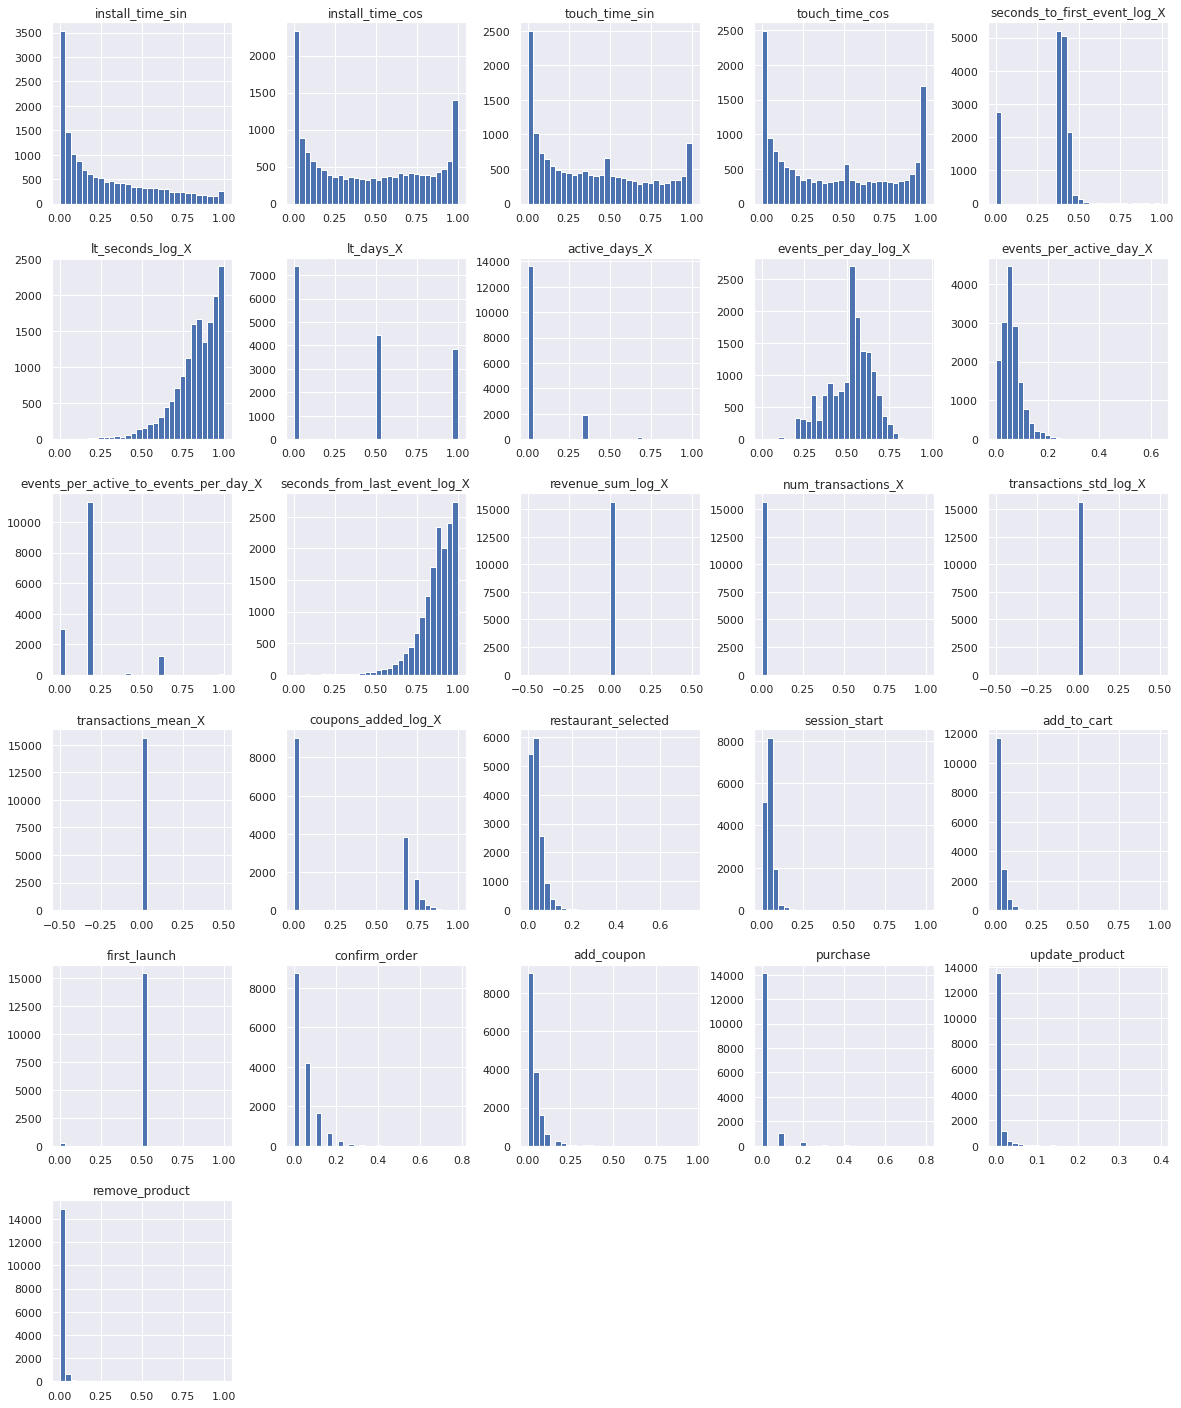

In [ ]:
pd.DataFrame(train_set['class_0']['X'][:, :len(num_cols_x)], columns=num_cols_x).hist(bins=30, figsize=(20,25));

In [ ]:
test_interval = pd.Interval(left=0, right=1.00, closed='both')

# train_p = pd.DataFrame(train_set['regr_1']['X']).applymap(lambda x: x if x in test_interval else 0) #.all(axis=1)

In [ ]:
np.bincount(train_set['class_0']['Y'])

array([12972,  3710])

In [ ]:
train_set['class_0']['R'].loc[1].describe()

,install_time_sin,install_time_cos,touch_time_sin,touch_time_cos,seconds_to_first_event_log_X,seconds_from_last_event_log_X,lt_seconds_X,lt_seconds_log_X,lt_days_X,active_days_X,events_per_day_X,events_per_day_log_X,events_per_active_day_X,events_per_active_to_events_per_day_X,revenue_sum_X,revenue_sum_log_X,num_transactions_X,transactions_std_log_X,transactions_mean_X,coupons_added_X,coupons_added_log_X,restaurant_selected,session_start,add_to_cart,first_launch,confirm_order,add_coupon,purchase,update_product,transaction,remove_product,seconds_to_first_event_log_Y,seconds_from_last_event_log_Y,lt_seconds_Y,lt_seconds_log_Y,lt_days_Y,active_days_Y,events_per_day_Y,events_per_day_log_Y,events_per_active_day_Y,events_per_active_to_events_per_day_Y,revenue_sum_Y,revenue_sum_log_Y,num_transactions_Y,transactions_std_log_Y,transactions_mean_Y,coupons_added_Y,coupons_added_log_Y,revenue_current,revenue_future,class0_target,class1_target,regr0_target,regr1_target,revenue_class
count,2527.000000,2527.000000,2483.000000,2483.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,646.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000
mean,-0.457420,-0.067597,-0.238470,-0.115828,-0.720692,11.777874,170277.658093,11.998719,1.476850,1.165018,7.717254,1.723003,8.758343,0.879897,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.548872,-4.607444,2.985754,2.042343,1.531856,0.979818,0.465374,0.548872,0.110803,0.343095,0.000000,0.276217,-0.720692,-6.907755,3022754.232291,14.674647,34.511278,4.458251,2.572646,0.293330,9.958910,0.231967,1638.732149,7.188177,1.430154,3.350197,1193.560729,2.671943,-0.597022,0.000000,1.000000,1.000000,1.000000,1638.732149,1638.732149,1.074001
std,0.539803,0.703649,0.639257,0.722109,2.833537,0.757681,50047.194099,0.311503,0.499563,0.404932,7.350859,0.788179,6.827658,0.401797,0.000000,0.000000,0.000000,0.000000,0.000000,1.115945,3.397314,2.462987,1.309940,2.589734,0.140650,0.955196,1.115945,0.419712,1.426413,0.000000,1.022162,2.833537,0.000000,1673472.885059,0.848858,19.368590,2.608330,5.643787,0.934533,4.779753,0.354085,1393.826144,0.603852,1.029152,4.578197,785.399089,2.863691,3.169512,0.000000,0.000000,0.000000,0.000000,1393.826144,1393.826144,0.805062
min,-1.000000,-1.000000,-1.000000,-1.000000,-6.907755,2.302585,86452.000000,11.367345,1.000000,1.000000,0.500000,-0.693147,1.000000,0.500000,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.907755,-6.907755,90172.000000,11.409474,1.000000,2.000000,0.183099,-1.697731,2.857143,0.025641,501.000000,6.216608,1.000000,-6.907755,265.666667,0.000000,-6.907755,0.000000,1.000000,1.000000,1.000000,501.000000,501.000000,0.000000
25%,-0.914739,-0.788838,-0.846928,-0.836226,0.000000,11.605149,126941.000000,11.751478,1.000000,1.000000,3.000000,1.098612,4.000000,0.500000,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.907755,1733944.000000,14.365909,20.000000,3.000000,0.727273,-0.318454,6.895833,0.089552,848.750000,6.743766,1.000000,4.055881,751.631250,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,848.750000,848.750000,0.000000
50%,-0.653200,-0.080271,-0.346322,-0.229979,0.000000,11.938069,168824.000000,12.036612,1.000000,1.000000,5.000000,1.609438,7.000000,1.000000,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755,2.000000,2.000000,0.00

In [ ]:
train_set['class_0']['R'].loc[0].describe()

,install_time_sin,install_time_cos,touch_time_sin,touch_time_cos,seconds_to_first_event_log_X,seconds_from_last_event_log_X,lt_seconds_X,lt_seconds_log_X,lt_days_X,active_days_X,events_per_day_X,events_per_day_log_X,events_per_active_day_X,events_per_active_to_events_per_day_X,revenue_sum_X,revenue_sum_log_X,num_transactions_X,transactions_std_log_X,transactions_mean_X,coupons_added_X,coupons_added_log_X,restaurant_selected,session_start,add_to_cart,first_launch,confirm_order,add_coupon,purchase,update_product,transaction,remove_product,seconds_to_first_event_log_Y,seconds_from_last_event_log_Y,lt_seconds_Y,lt_seconds_log_Y,lt_days_Y,active_days_Y,events_per_day_Y,events_per_day_log_Y,events_per_active_day_Y,events_per_active_to_events_per_day_Y,revenue_sum_Y,revenue_sum_log_Y,num_transactions_Y,transactions_std_log_Y,transactions_mean_Y,coupons_added_Y,coupons_added_log_Y,revenue_current,revenue_future,class0_target,class1_target,regr0_target,regr1_target,revenue_class
count,13115.000000,13115.000000,12896.000000,12896.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13114.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000,13115.000000
mean,-0.430363,-0.105248,-0.212318,-0.129459,-0.766966,10.868849,99343.402745,11.143566,0.638582,1.135799,12.751582,2.349717,12.881345,1.007358,0.000000,-6.907755,0.000457,-6.907755,0.000000,0.786047,-3.672339,3.917652,2.325276,2.619062,0.986961,0.780099,0.786047,0.146931,0.622112,0.000457,0.452993,-0.766966,-6.907755,967661.163401,10.129178,10.946092,2.104689,10.227284,1.607773,11.684444,0.770542,0.000000,-6.907755,0.001830,-6.907755,0.000000,0.995273,-3.118603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.566230,0.695094,0.654627,0.713931,2.902817,1.233402,71510.140149,1.003198,0.794832,0.368538,7.747882,0.672694,7.372814,0.348644,0.000000,0.000000,0.052392,0.000000,0.000000,1.259088,3.649094,2.648187,1.456982,2.914637,0.115443,1.116304,1.259088,0.522621,1.540347,0.052392,1.331903,2.902817,0.000000,1584026.780309,3.834293,18.182469,2.007711,8.729851,1.506230,6.892340,0.528805,0.000000,0.000000,0.113842,0.000000,0.000000,1.501555,3.707838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,-1.000000,-1.000000,-1.000000,-1.000000,-6.907755,1.386294,221.000000,5.398167,0.000000,1.000000,0.500000,-0.693147,1.000000,0.500000,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.907755,-6.907755,1.000000,0.001000,0.000000,1.000000,0.128205,-2.054124,1.333333,0.024096,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.918806,-0.802340,-0.840015,-0.831318,0.000000,10.324760,42048.500000,10.646579,0.000000,1.000000,7.500000,2.014903,8.000000,1.000000,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.907755,566.000000,6.338596,0.000000,1.000000,1.222222,0.200671,6.250000,0.190476,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.632705,-0.171499,-0.331612,-0.255938,0.000000,11.092535,78929.000000,11.276304,0.000000,1.000000,12.000000,2.484907,12.000000,1.000000,0.000000,-6.907755,0.000000,-6.907755,0.000000,0.000000,-6.907755,3.000000,2.0

### Training

In [ ]:
from sklearn.metrics import plot_precision_recall_curve, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

In [ ]:
tf.random.set_seed(0)

In [ ]:
class ModelManager():
    def __init__(self, train_X, train_Y, test_X, test_Y, eval_X=None, eval_Y=None, problem='regr', 
                 layer_sizes=[16]):
        self.train_X = train_X
        self.train_Y = train_Y
        self.test_X = test_X
        self.test_Y = test_Y
        self.eval_X = eval_X
        self.eval_Y = eval_Y
        self.layer_sizes = layer_sizes

        self.problem = problem

        if (self.problem == 'class'):
            self.metrics = [
                keras.metrics.TruePositives(name='tp'),
                keras.metrics.FalsePositives(name='fp'),
                keras.metrics.TrueNegatives(name='tn'),
                keras.metrics.FalseNegatives(name='fn'), 
                keras.metrics.BinaryAccuracy(name='accuracy'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc'),
                keras.metrics.AUC(name='prc', curve='PR')
                ]

            self.loss = keras.losses.BinaryCrossentropy()
        else:
            self.metrics = [
                tf.keras.metrics.MeanAbsoluteError(name='MAE')]

            self.loss = tf.keras.losses.MeanAbsoluteError()

        self.model = self.create_model()
        self.compile_model()

    def create_model(self, output_bias_value=None):
        if (output_bias_value is not None):
            output_bias = output_bias_value
        elif (self.problem == 'class'):
            counts = pd.Series(self.train_Y).value_counts()
            output_bias = np.log([counts.loc[1]/counts.loc[0]])
        elif (self.problem == 'regr'):
            output_bias = self.train_Y.mean()
        else:
            output_bias = None

        initializer = tf.keras.initializers.Constant(value=output_bias) if output_bias is not None else None

        def create_layer(src):
            if (isinstance(src, int)):
                return tf.keras.layers.Dense(src, activation=tf.nn.relu)
            elif (isinstance(src, float) and src > 0 and src < 1):
                return tf.keras.layers.Dropout(src)
            elif (isinstance(src, dict) and 'size' in src.keys() and 'activation' in src.keys()):
                return tf.keras.layers.Dense(src['size'], activation=src['activation'])
            else:
                print("Unknown layer config: ", src)
                return None

        return keras.models.Sequential([
            tf.keras.Input(shape=(self.train_X.shape[-1],))] + \
            [create_layer(x) for x in self.layer_sizes] + \
            [tf.keras.layers.Dense(1, activation=('linear' if (self.problem == 'regr') else 'sigmoid'), 
                    bias_initializer=initializer)  
        ])


    def model_summary(self):
        self.model.summary()

    def compile_model(self):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=3e-4, name='Adam'),
              loss=self.loss,
              metrics=self.metrics)
        
    def plot_history(self):
        plt.plot(self.history.epoch, self.history.history['loss'])
        if ('val_loss' in self.history.history):
            plt.plot(self.history.epoch, self.history.history['val_loss'])

    def plot_targets(self):
        plt.hist(self.train_Y)

    def fit_model(self, use_early_stopping=True, callback_metric='loss', epochs=100, stop_delta=1, patience=5,
                  use_class_weights=False, sample_weight_regr=None, batch_size=64):
        if (self.problem == 'class' and use_class_weights is True):
            counts = np.bincount(train_set['class_0']['Y'])
            weight_for_0, weight_for_1 = (1 / counts) * (np.sum(counts) / 2)

            class_weight = {0: weight_for_0, 1: weight_for_1}
            print('Class weights: ', class_weight)
            sample_weight = None
        elif (self.problem == 'regr' and sample_weight_regr is not None):
            sample_weight = sample_weight_regr
            class_weight = None
        else:
            class_weight = None
            sample_weight = None

        callback = tf.keras.callbacks.EarlyStopping(monitor=callback_metric,
                                            patience=patience,
                                            min_delta=stop_delta,
                                            restore_best_weights=True)
        
        print('Fitiing on ', self.train_X.shape)
        self.history = self.model.fit(self.train_X, self.train_Y, batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(self.eval_X, self.eval_Y) if self.eval_X is not None else None,
                    callbacks=[callback] if use_early_stopping is True else None,
                    class_weight=class_weight,
                    sample_weight=sample_weight)
        
    def run_overfit(self, n_samples=4, epochs=500):
        subset_X = self.train_X[:n_samples]
        subset_Y = self.train_Y[:n_samples]
        print('(Over-)Fitiing on ', subset_X.shape, subset_Y.shape)
        self.history = self.model.fit(subset_X, subset_Y, 
                    epochs=epochs)
    
    def run_dummpy(self):
        if (self.problem == 'regr'):
            model = DummyRegressor()
        else:
            model = DummyClassifier(strategy='prior')
        model.fit(self.train_X, self.train_Y)
        test_X = self.eval_X if self.eval_X is not None else self.test_X
        test_Y = self.eval_Y if self.eval_Y is not None else self.test_Y
        predict = model.predict(test_X)
        print("{}\tMAE train =".format(type(model).__name__), '{:5.4f}'.format(mean_absolute_error(test_Y, predict)), "\tscore = ", '{:5.4f}'.format(model.score(test_X, test_Y)))
        return predict

    def run_simple(self):
        model = None
        test_X = self.eval_X if self.eval_X is not None else self.test_X
        test_Y = self.eval_Y if self.eval_Y is not None else self.test_Y
        
        if (self.problem == 'regr'):
            model = LinearRegression()
            model.fit(self.train_X, self.train_Y)
            predict = model.predict(test_X)
            print("{}\tMAE eval =".format(type(model).__name__), '{:5.4f}'.format(mean_absolute_error(test_Y, predict)), "\tscore = ", '{:5.4f}'.format(model.score(test_X, test_Y)))    
        else:
            model = KNeighborsClassifier()
            model.fit(self.train_X, self.train_Y)
            predict = model.predict(test_X)
            print("{}\tscore = {:5.4f}".format(type(model).__name__, model.score(test_X, test_Y)))
            print("{} confusion matrix: \n".format(type(model).__name__), confusion_matrix(test_Y, predict))
        return predict
        
    def evaluate(self):
        test_X = self.eval_X if self.eval_X is not None else self.test_X
        test_Y = self.eval_Y if self.eval_Y is not None else self.test_Y

        if (self.problem == 'regr'):
            test_results = self.model.evaluate(test_X, test_Y)
            train_results = self.model.evaluate(self.train_X, self.train_Y)
            print("train loss = {}\ntest loss = {}\ntest acc = {}\nacc % = {}"
                    .format(train_results[0], test_results[0], test_results[1], 1 - test_results[1] / test_Y.mean()))
        else:
            test_results = self.model.evaluate(test_X, test_Y)
            train_results = self.model.evaluate(self.train_X, self.train_Y)
            print("train loss = {}\ntest loss = {}\ntest acc = {}\nacc % = {}"
                    .format(train_results[0], test_results[0], test_results[1], 1 - test_results[1] / test_Y.mean()))
            print("Metrics: ", test_results)

    def get_predict_fact_df(self):
        return pd.DataFrame({'Fact': self.test_Y, 
                'Predict': self.model.predict(self.test_X)[:, 0],
                # 'On': test_set['U']['revenue_sum_X'],
                # 'Lt days X': test_set['class_0']['R']['lt_days_X'],
                # 'Lt days Y': test_set['class_0']['R']['lt_days_Y'],
            })

    def save_model(self, name):
        self.model.save('{}.h5'.format(name))

    def load_model(self, name):
        self.model = tf.keras.models.load_model('{}.h5'.format(name))

In [ ]:
manager_class0 = ModelManager(train_set['class_0']['X'], train_set['class_0']['Y'],
                             test_set['class_0']['X'], test_set['class_0']['Y'],
                             problem='class',  layer_sizes=[128, 0.2, 512, 1024, 256, 128, 64, 32, 16],
                             eval_X=eval_set['class_0']['X'] if eval_set is not None else None, eval_Y=eval_set['class_0']['Y'] if eval_set is not None else None)

manager_class1 = ModelManager(train_set['class_1']['X'], train_set['class_1']['Y'],
                             test_set['class_1']['X'], test_set['class_1']['Y'],
                             problem='class', layer_sizes=[128, 0.2, 512, 1024, 256, 128, 64, 32, 16],
                             eval_X=eval_set['class_1']['X'] if eval_set is not None else None, eval_Y=eval_set['class_1']['Y'] if eval_set is not None else None)

manager_regr0 = ModelManager(train_set['regr_0']['X'], train_set['regr_0']['Y'],
                             test_set['regr_0']['X'], test_set['regr_0']['Y'],
                             problem='regr', layer_sizes=[128, 0.2, 256, 512, 1024, 256, 128, 64, 32, 16, 8],
                             eval_X=eval_set['regr_0']['X'] if eval_set is not None else None, eval_Y=eval_set['regr_0']['Y'] if eval_set is not None else None)

manager_regr1 = ModelManager(train_set['regr_1']['X'], train_set['regr_1']['Y'],
                             test_set['regr_1']['X'], test_set['regr_1']['Y'],
                             problem='regr', layer_sizes=[128, 0.2, 256, 512, 1024, 256, 128, 64, 32, 16, 8],
                             eval_X=eval_set['regr_1']['X'] if eval_set is not None else None, eval_Y=eval_set['regr_1']['Y'] if eval_set is not None else None)

In [ ]:
manager_class0.run_dummpy();
manager_class1.run_dummpy();
manager_regr0.run_dummpy();
manager_regr1.run_dummpy();

DummyClassifier	MAE train = 0.1614 	score =  0.8386
DummyClassifier	MAE train = 0.1835 	score =  0.8165
DummyRegressor	MAE train = 931.9965 	score =  -0.0011
DummyRegressor	MAE train = 1217.1391 	score =  -0.0008


In [ ]:
manager_class0.run_simple();
manager_class1.run_simple();
manager_regr0.run_simple();
manager_regr1.run_simple();

KNeighborsClassifier	score = 0.8009
KNeighborsClassifier confusion matrix: 
 [[2990  253]
 [ 517  107]]
KNeighborsClassifier	score = 0.7599
KNeighborsClassifier confusion matrix: 
 [[2979  313]
 [ 655   85]]
LinearRegression	MAE eval = 302172704307.1549 	score =  -14872336340929290240.0000
LinearRegression	MAE eval = 966.3979 	score =  0.3785


In [ ]:
manager_class0.evaluate()

489/489 [==============================] - 3s 6ms/step - loss: 0.4428 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 13115.0000 - fn: 2527.0000 - accuracy: 0.8384 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4860 - prc: 0.1549
train loss = 0.4428079128265381
test loss = 0.44243642687797546
test acc = 0.0
acc % = 1.0
Metrics:  [0.44243642687797546, 0.0, 0.0, 3243.0, 624.0, 0.8386346101760864, 0.0, 0.0, 0.49016720056533813, 0.15613138675689697]


In [ ]:
manager_class0.run_overfit()

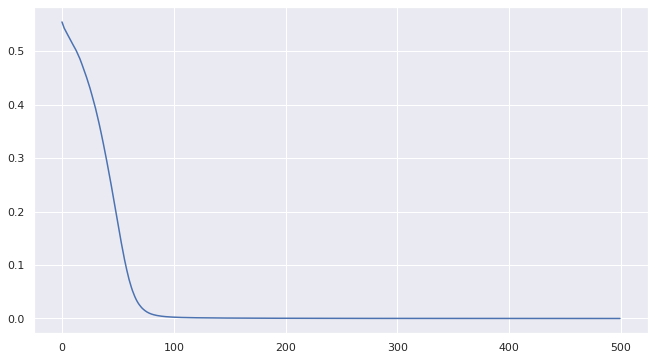

In [ ]:
manager_class0.plot_history()

In [ ]:
manager_class0.fit_model(use_early_stopping=True, callback_metric='val_loss', stop_delta=0.01, patience=50, epochs=1000,
                         use_class_weights=True, batch_size=64)

In [ ]:
manager_class0.evaluate()

489/489 [==============================] - 3s 6ms/step - loss: 0.4081 - tp: 2411.0000 - fp: 4715.0000 - tn: 8400.0000 - fn: 116.0000 - accuracy: 0.6912 - precision: 0.3383 - recall: 0.9541 - auc: 0.8440 - prc: 0.4237
train loss = 0.4080961346626282
test loss = 0.4293554127216339
test acc = 577.0
acc % = -3574.7355769230767
Metrics:  [0.4293554127216339, 577.0, 1221.0, 2022.0, 47.0, 0.6720972061157227, 0.32091212272644043, 0.9246794581413269, 0.814189076423645, 0.36982831358909607]


In [ ]:
confusion_matrix(manager_class0.test_Y, manager_class0.model.predict(manager_class0.test_X) > 0.55)

array([[2776, 1314],
       [ 119,  669]])

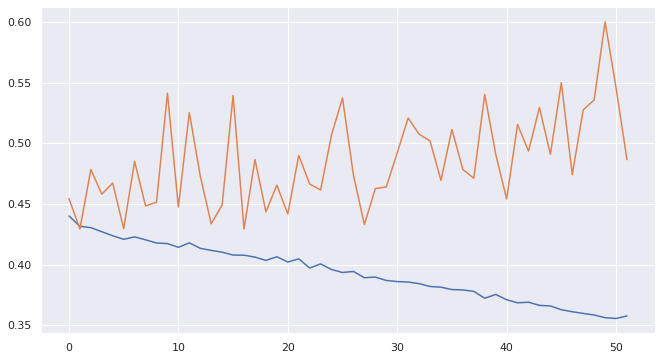

In [ ]:
manager_class0.plot_history()

In [ ]:
manager_class1.fit_model(use_early_stopping=True, callback_metric='val_loss', stop_delta=0.01, patience=50, epochs=1000,
                         use_class_weights=True, batch_size=64)

In [ ]:
manager_regr0.fit_model(use_early_stopping=True, callback_metric='val_loss', stop_delta=1, patience=50, epochs=1000)

In [ ]:
manager_regr0.evaluate()

79/79 [==============================] - 0s 5ms/step - loss: 785.4182 - MAE: 785.4182
train loss = 785.418212890625
test loss = 842.6253051757812
test acc = 842.6253051757812
acc % = 0.49996289610192024


In [ ]:
manager_regr1.fit_model(use_early_stopping=True, callback_metric='val_loss', stop_delta=1, patience=50, epochs=1000)

In [ ]:
manager_regr1.evaluate()

101/101 [==============================] - 1s 5ms/step - loss: 821.4668 - MAE: 821.4668
train loss = 821.466796875
test loss = 886.6348876953125
test acc = 886.6348876953125
acc % = 0.6920449511262179


In [ ]:
manager_regr0.get_predict_fact_df()

,Fact,Predict
0,999.000000,1254.793945
1,1197.000000,1230.355713
2,899.000000,1241.325562
3,599.000000,1274.370605
4,1399.000000,1148.078125
...,...,...
783,999.000000,1135.915283
784,999.000000,1201.519165
785,691.740000,1094.052856
786,2297.000000,1245.797119


In [ ]:
doSaveModels = True

if (doSaveModels):
    manager_regr1.save_model(path.join(DRIVE_ROOT, 'colab/models/regr1'))
    manager_regr0.save_model(path.join(DRIVE_ROOT, 'colab/models/regr0'))
    manager_class0.save_model(path.join(DRIVE_ROOT, 'colab/models/class0'))
    manager_class1.save_model(path.join(DRIVE_ROOT, 'colab/models/class1'))

In [ ]:
manager_regr = ModelManager(train_set['U_X'], train_set['U_Y'],
                             test_set['U_X'], test_set['U_Y'],
                             eval_X=eval_set['U_X'], eval_Y=eval_set['U_Y'],
                             problem='regr', layer_sizes=[128, 0.2, 256, 0.2, 128, 64, 32, 16, 8])

In [ ]:
# manager_regr.run_overfit()

In [ ]:
manager_regr.run_simple();

LinearRegression	MAE eval = 4405446764.9370 	score =  -94139686053663984.0000


In [ ]:
manager_regr.fit_model(use_early_stopping=False, epochs=3000, patience=15, sample_weight_regr=np.log(np.clip(train_set['U_Y'], 1, 100000)) / np.log(1.5) + 1)

Streaming output truncated to the last 5000 lines.
Epoch 501/3000
494/494 [==============================] - 3s 6ms/step - loss: 5251.1376 - MAE: 654.4879 - val_loss: 725.7963 - val_MAE: 725.7963
Epoch 502/3000
494/494 [==============================] - 3s 6ms/step - loss: 5243.5913 - MAE: 656.1549 - val_loss: 717.4280 - val_MAE: 717.4280
Epoch 503/3000
494/494 [==============================] - 3s 6ms/step - loss: 5383.0429 - MAE: 655.4594 - val_loss: 716.2219 - val_MAE: 716.2219
Epoch 504/3000
494/494 [==============================] - 3s 6ms/step - loss: 5224.8566 - MAE: 662.4070 - val_loss: 706.8565 - val_MAE: 706.8565
Epoch 505/3000
494/494 [==============================] - 3s 6ms/step - loss: 5325.6057 - MAE: 656.7795 - val_loss: 709.3106 - val_MAE: 709.3106
Epoch 506/3000
494/494 [==============================] - 3s 6ms/step - loss: 5235.5709 - MAE: 652.4324 - val_loss: 707.2721 - val_MAE: 707.2721
Epoch 507/3000
494/494 [==============================] - 3s 6ms/step - loss: 5

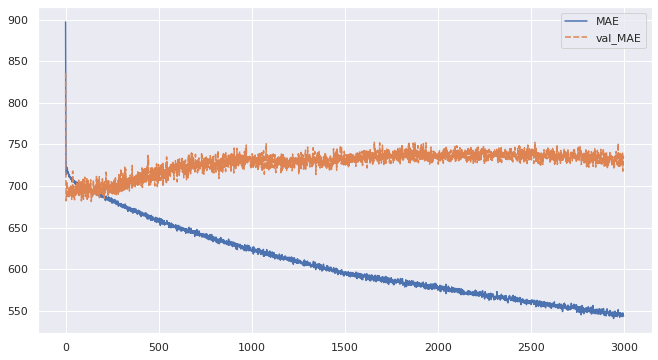

In [ ]:
sns.lineplot(data=pd.DataFrame(manager_regr.history.history)[['MAE', 'val_MAE']]);

In [ ]:
manager_regr.evaluate()

988/988 [==============================] - 1s 1ms/step - loss: 600.9284 - MAE: 600.9284
train loss = 600.9284057617188
test loss = 736.4532470703125
test acc = 736.4532470703125
acc % = 0.21717814728567697


In [ ]:
manager_regr.get_predict_fact_df()

,Fact,Predict
0,599.000000,713.689819
1,0.000000,713.689819
2,2994.000000,2204.482910
3,999.000000,1001.810669
4,1232.000000,1090.433960
...,...,...
9868,0.000000,980.571960
9869,1933.650000,2408.155273
9870,4196.000000,999.459717
9871,908.700000,1127.229736


In [ ]:
manager_regr.save_model(path.join(DRIVE_ROOT, 'colab/models/general_regr'))

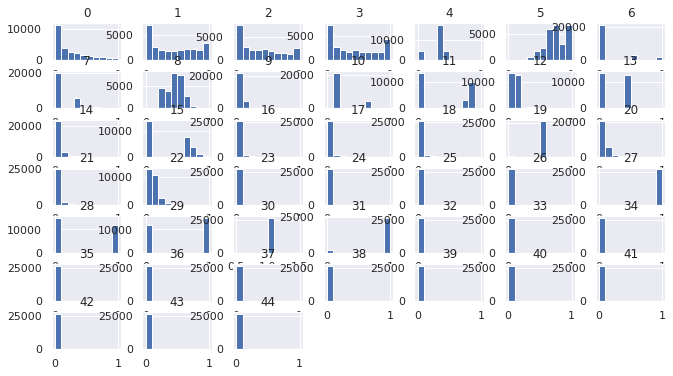

In [ ]:
pd.DataFrame(manager_regr.train_X).hist();

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing as tf_preprocessing
from tensorflow import feature_column
from tensorflow.data.experimental import rejection_resample

In [ ]:
numeric_cols = ['seconds_to_first_event_log_X', 'lt_seconds_log_X',
       'lt_days_X', 'active_days_X',
       'events_per_day_log_X', 'events_per_active_day_X',
       'events_per_active_to_events_per_day_X',
       'revenue_sum_log_X', 'num_transactions_X',
       'transactions_std_log_X', 'transactions_mean_X',
       'coupons_added_X', 'coupons_added_log_X', 'restaurant_selected',
       'session_start', 'add_to_cart', 'first_launch', 'confirm_order',
       'add_coupon', 'purchase', 'update_product', 'transaction',
       'remove_product']

embed_cols = ['most_common_location_X', 'most_common_upsell_code_X', 
            #   'install_time_sin', 'install_time_cos', 'touch_time_sin', 'touch_time_cos'
              ]

cat_cols = ['region', 'platform']

all_x_cols = numeric_cols + embed_cols + cat_cols

In [ ]:
def df_to_dataset(df, target_col, shuffle=True, batch_size=32):
    dataframe = df.copy()
    labels = dataframe.pop(target_col)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if (shuffle):
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    return (feature_layer(example_batch).numpy())

def get_normalization_layer(name, dataset):
    normalizer = tf_preprocessing.Normalization()
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)

    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = tf_preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = tf_preprocessing.IntegerLookup(max_values=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = tf_preprocessing.CategoryEncoding(max_tokens=index.vocab_size())
    return lambda feature: encoder(index(feature))

def create_numeric_layers(df, column_names):
    result = []
    for col_name in column_names:
        result.append(feature_column.numeric_column(col_name))
    return result

def create_categorical_layers(df, column_names):
    result = []
    for col_name in column_names:
        categorical_column = feature_column.categorical_column_with_vocabulary_list(
            col_name, df[col_name].astype(str).unique())
        indicator_column = feature_column.indicator_column(categorical_column)
        result.append(indicator_column)
    return result

def create_category_embedded_layer(df, column_names):
    result = []
    for col_name in column_names:
        categorical_column = feature_column.categorical_column_with_vocabulary_list(
            col_name, df[col_name].astype(str).unique())
        embedded_column = feature_column.embedding_column(categorical_column, dimension=8)
        result.append(embedded_column)
    return result

class PretrainConverter():
    def __init__(self, type_map):
        if (not isinstance(type_map, dict)):
            print("type_map must be dict, got {}".format(type_map))
            return
        self.type_map = type_map

    def run(self, df, fill_with_blank=True):
        result = df.copy()
        if (fill_with_blank is True):
            result = result.fillna({**{x: '' for x in result.select_dtypes([object])}, **{x: 0.0 for x in result.select_dtypes([np.number])}})
        for col, dtype in self.type_map.items():
            result[col] = result[col].astype(dtype)
        return result

converter = PretrainConverter({**{x: str for x in cat_cols + embed_cols}, **{x: np.float32 for x in numeric_cols}})

### Classification model type 0

In [ ]:
# converter.run(train_data.loc[0][all_x_cols + ['class0_target']])

In [ ]:
batch_size = 32
train_ds = df_to_dataset(converter.run(train_data.loc[0][all_x_cols + ['class0_target']]), 'class0_target', batch_size=batch_size)
test_ds = df_to_dataset(converter.run(test_data.loc[0][all_x_cols + ['class0_target']]), 'class0_target', shuffle=False, batch_size=batch_size)

In [ ]:
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=522>

In [ ]:
all_inputs = {
    **{col: keras.Input(shape=(1,), name=col, dtype=np.float32) for col in numeric_cols},
    **{col: keras.Input(shape=(1,), name=col, dtype=tf.string) for col in cat_cols + embed_cols}
    }

In [ ]:
normalizers = [get_normalization_layer(col, train_ds)(all_inputs[col]) for col in numeric_cols]
categorizers = [get_category_encoding_layer(col, train_ds, 'string')(all_inputs[col]) for col in embed_cols + cat_cols]

In [ ]:
preprocessors = normalizers + categorizers

In [ ]:
test_ds.map(lambda x, y: x)

<MapDataset shapes: {seconds_to_first_event_log_X: (None,), lt_seconds_log_X: (None,), lt_days_X: (None,), active_days_X: (None,), events_per_day_log_X: (None,), events_per_active_day_X: (None,), events_per_active_to_events_per_day_X: (None,), revenue_sum_log_X: (None,), num_transactions_X: (None,), transactions_std_log_X: (None,), transactions_mean_X: (None,), coupons_added_X: (None,), coupons_added_log_X: (None,), restaurant_selected: (None,), session_start: (None,), add_to_cart: (None,), first_launch: (None,), confirm_order: (None,), add_coupon: (None,), purchase: (None,), update_product: (None,), transaction: (None,), remove_product: (None,), most_common_location_X: (None,), most_common_upsell_code_X: (None,), region: (None,), platform: (None,)}, types: {seconds_to_first_event_log_X: tf.float32, lt_seconds_log_X: tf.float32, lt_days_X: tf.float32, active_days_X: tf.float32, events_per_day_log_X: tf.float32, events_per_active_day_X: tf.float32, events_per_active_to_events_per_day_X:

In [ ]:
preprocessing_layer = layers.concatenate(preprocessors)

# normalizer = preprocessing.Normalization()
# normalizer.adapt(train_ds.map(lambda x, y: x))

In [ ]:
train_data.loc[0]['class0_target'].value_counts()

1.000000    16774
Name: class0_target, dtype: int64

In [ ]:
counts = pd.Series(train_data['class0_target']).value_counts()
output_bias = np.log([counts.loc[0]/counts.loc[1]])
initializer = tf.keras.initializers.Constant(value=output_bias) 

class_counts = train_data.loc[0]['class0_target'].value_counts()
class_weights = dict((train_data.loc[0]['class0_target'].count() - class_counts) / class_counts.min())
print("Class weights: ", class_weights)

x = tf.keras.layers.Dense(128, activation="relu")(preprocessing_layer)
x = tf.keras.layers.Dense(256, activation="relu")(preprocessing_layer)
x = tf.keras.layers.Dense(512, activation="relu")(preprocessing_layer)
x = tf.keras.layers.Dense(128, activation="relu")(preprocessing_layer)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(8, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=initializer)(x)
model = tf.keras.Model(all_inputs, output)

model.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=3e-4, name='Adam'),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.TruePositives(name='tp'),
                keras.metrics.FalsePositives(name='fp'),
                keras.metrics.TrueNegatives(name='tn'),
                keras.metrics.FalseNegatives(name='fn'), 
                keras.metrics.BinaryAccuracy(name='accuracy'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc')])

Class weights:  {0.0: 1.0, 1.0: 3.496495956873315}


In [ ]:
for features, label in train_ds.take(2):
    print(label.numpy().flatten().mean())

0.25
0.21875


In [ ]:
history = model.fit(train_ds.take(4), epochs=200, class_weight=class_weights)

Epoch 1/200
4/4 [==============================] - 0s 7ms/step - loss: 0.6949 - tp: 17.0000 - fp: 34.0000 - tn: 74.0000 - fn: 3.0000 - accuracy: 0.7109 - precision: 0.3333 - recall: 0.8500 - auc: 0.8134
Epoch 2/200
4/4 [==============================] - 0s 8ms/step - loss: 0.6120 - tp: 24.0000 - fp: 20.0000 - tn: 78.0000 - fn: 6.0000 - accuracy: 0.7969 - precision: 0.5455 - recall: 0.8000 - auc: 0.9041
Epoch 3/200
4/4 [==============================] - 0s 8ms/step - loss: 0.7774 - tp: 25.0000 - fp: 32.0000 - tn: 65.0000 - fn: 6.0000 - accuracy: 0.7031 - precision: 0.4386 - recall: 0.8065 - auc: 0.8357
Epoch 4/200
4/4 [==============================] - 0s 8ms/step - loss: 0.6601 - tp: 21.0000 - fp: 34.0000 - tn: 66.0000 - fn: 7.0000 - accuracy: 0.6797 - precision: 0.3818 - recall: 0.7500 - auc: 0.8461
Epoch 5/200
4/4 [==============================] - 0s 8ms/step - loss: 0.8846 - tp: 30.0000 - fp: 36.0000 - tn: 56.0000 - fn: 6.0000 - accuracy: 0.6719 - precision: 0.4545 - recall: 0.8333

In [ ]:
model.evaluate(test_ds)

131/131 [==============================] - 0s 3ms/step - loss: 1.2222 - tp: 447.0000 - fp: 1259.0000 - tn: 1984.0000 - fn: 481.0000 - accuracy: 0.5828 - precision: 0.2620 - recall: 0.4817 - auc: 0.5607


[1.2222102880477905,
 447.0,
 1259.0,
 1984.0,
 481.0,
 0.5828338265419006,
 0.2620164155960083,
 0.48168104887008667,
 0.560693621635437]

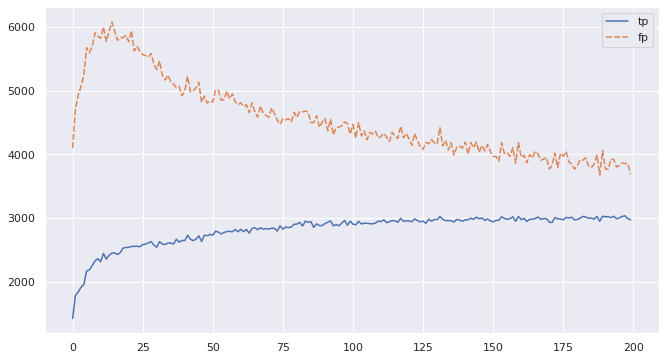

In [ ]:
sns.lineplot(data=pd.DataFrame(history.history, index=history.epoch)[['tp', 'fp']]);

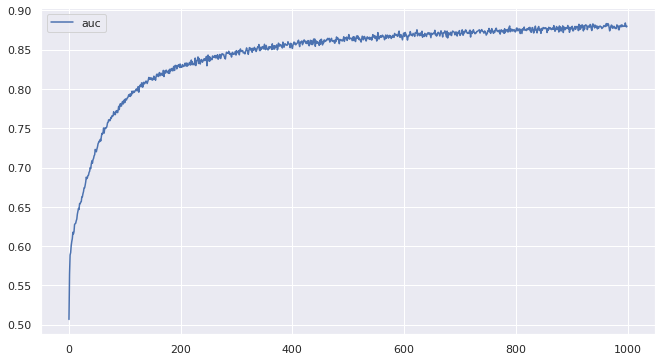

In [ ]:
sns.lineplot(data=pd.DataFrame(history.history, index=history.epoch)[['auc']]);

In [ ]:
model.summary()

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Assemble models

In [ ]:
from joblib import load

PIPELINES_DIR = 'colab/pipelines'
MODELS_DIR = 'colab/models'

class MyEnsembleManager():
    def __init__(self, prerpoc_pipeline, class0_model, class1_model, regr0_model, regr1_model):
        self.num_cols_x = ['install_time_sin', 'install_time_cos', 'touch_time_sin', 'touch_time_cos', 
            'seconds_to_first_event_log_X', 'lt_seconds_log_X', 
            'lt_days_X', 
            'active_days_X',
            'events_per_day_log_X', 'events_per_active_day_X',
            'events_per_active_to_events_per_day_X', 
            'revenue_sum_X',
            'num_transactions_X', 'transactions_std_log_X',
            'transactions_mean_X', 
            'coupons_added_log_X',
            'restaurant_selected', 'session_start', 'add_to_cart', 'first_launch',
            'confirm_order', 'add_coupon', 'purchase', 'update_product',
            'remove_product']
        self.str_cols_x = ['region', 'platform', 'most_common_location_X', 'most_common_upsell_code_X']
        self.x_cols = num_cols_x + str_cols_x

        def load_arg(arg, path_to_load, desired_type, arg_name):
            if (isinstance(arg, str)):
                loaded = tf.keras.models.load_model(path.join(path_to_load, arg)) if arg.split('.')[-1] == 'h5' else load(path.join(path_to_load, arg))
            else:
                loaded = arg

            if (isinstance(loaded, desired_type)):
                return loaded
            else:
                raise Exception("{} must be instance of {} or a path to such, got arg={}, loaded={}.".format(arg_name, desired_type, type(arg), type(loaded)))

        self.prerpoc_pipeline = load_arg(prerpoc_pipeline, path.join(DRIVE_ROOT, PIPELINES_DIR), sklearn.pipeline.FeatureUnion, 'prerpoc_pipeline')
        self.class0_model = load_arg(class0_model, path.join(DRIVE_ROOT, MODELS_DIR), tf.keras.Model, 'class0_model')
        self.class1_model = load_arg(class1_model, path.join(DRIVE_ROOT, MODELS_DIR), tf.keras.Model, 'class1_model')
        self.regr0_model = load_arg(regr0_model, path.join(DRIVE_ROOT, MODELS_DIR), tf.keras.Model, 'regr0_model')
        self.regr1_model = load_arg(regr1_model, path.join(DRIVE_ROOT, MODELS_DIR), tf.keras.Model, 'regr1_model')
        
    def run(self, df):
        metric_to_split_classes = 'revenue_sum_X'
        df['class'] = (df[metric_to_split_classes] > 0).astype(int)

        class0_idxs = df[df['class'] == 0].index
        class1_idxs = df[df['class'] == 1].index

        class0_pred = pd.DataFrame({'Prediction': self.apply_class_and_regression(df.loc[class0_idxs].copy(),
                                        self.class0_model, self.regr0_model, df.loc[class0_idxs][metric_to_split_classes])}, index=class0_idxs)
        class1_pred = pd.DataFrame({'Prediction': self.apply_class_and_regression(df.loc[class1_idxs].copy(),
                                        self.class1_model, self.regr1_model, df.loc[class1_idxs][metric_to_split_classes])}, index=class1_idxs)
        
        prediction = pd.concat([class0_pred, class1_pred]).reindex(df.index)

        return prediction

    def apply_class_and_regression(self, df, class_model, regr_model, fill_neg_classed_values):
        preprocessed = self.prerpoc_pipeline.transform(df.replace({pd.NA: np.nan})).todense()
        df['prediction'] = np.array(class_model.predict(preprocessed) > 0.53, dtype=int)
        pos_pred_mask = df['prediction'] > 0
        neg_pred_mask = pos_pred_mask == False
        pos_pred_idxs = df[pos_pred_mask].index
        neg_pred_idxs = df[neg_pred_mask].index

        df.loc[neg_pred_idxs, 'prediction'] = fill_neg_classed_values[neg_pred_mask]

        if (len(pos_pred_idxs) > 0):
            regr_pred = regr_model.predict(preprocessed[pos_pred_mask])
            df.loc[pos_pred_idxs, 'prediction'] = regr_pred

        return df['prediction'].to_numpy()



In [ ]:
ensemble = MyEnsembleManager('dominos_pipeline.joblib', 'class0.h5', 'class1.h5', 'regr0.h5', 'regr1.h5')

In [ ]:
fpred = ensemble.run(D)

In [ ]:
fpred.mean()

Prediction   1258.450250
dtype: float64

In [ ]:
D['revenue_sum_Y'].mean()

930.7971047671928

In [ ]:
fpred

Prediction
revenue_current revenue_future appsflyer_id                                 
0               0              1454310470000-2387024             1297.355347
                               1465317772000-4475072                0.000000
                               1480077853000-5465448                0.000000
                               1481869041000-2103144                0.000000
                               1482401238000-0782613                0.000000
...                                                                      ...
1               1              1615830468509-1619568287117979240 2173.098389
                               1615833716789-1937144             3111.231445
                               1615836158551-9382078             1669.578369
                               1615838386704-1780476140459202721 1099.000000
                               1615839239782-3027286             4346.000000

[50407 rows x 1 columns]

In [ ]:
D[['revenue_sum_Y']].shape #.join(fpred.reset_index(), on='appsflyer_id')

(50407, 1)

In [ ]:
result = pd.DataFrame({'Fact': D['revenue_sum_Y'].values, 'Predict': fpred['Prediction'].values, 'On': D['revenue_sum_X'].values})
result[result['On'] > 0]

,Fact,Predict,On
24723,2849.000000,2849.000000,2849.000000
24724,4949.000000,4949.000000,4949.000000
24725,1426.000000,1426.000000,1426.000000
24726,799.000000,799.000000,799.000000
24727,1997.000000,1997.000000,1997.000000
...,...,...,...
50402,2425.140000,2173.098389,1114.140000
50403,2765.000000,3111.231445,1767.000000
50404,1772.800000,1669.578369,550.550000
50405,2098.000000,1099.000000,1099.000000


In [ ]:
print("MAE = ", (result['Fact'] - result['Predict']).abs().mean())

MAE =  598.6129500858154


In [ ]:
def CohenEffectSize(dist1, dist2):
    diff = dist1.mean() - dist2.mean()

    var1, var2 = dist1.var(), dist2.var()
    c1, c2 = len(dist1), len(dist2)
    pooled_var = (var1 * c1 + var2 * c2)/(c1 + c2)
    return diff / (np.sqrt(pooled_var))

In [ ]:
CohenEffectSize(train_set['regr_1']['R']['revenue_sum_Y'], train_set['regr_0']['R']['revenue_sum_Y'])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=0).fit(train_set['class_0']['X'], train_set['class_0']['Y'], sample_weight=(train_set['class_0']['Y'] * 3) + 1)
gb_clf.score(test_set['class_0']['X'], test_set['class_0']['Y'])

In [ ]:
confusion_matrix(test_set['class_0']['Y'], gb_clf.predict(test_set['class_0']['X']))

In [ ]:
plot_precision_recall_curve(gb_clf, test_set['class_0']['X'], test_set['class_0']['Y']);

In [ ]:
((train_set['class_0']['Y'] * 3) + 1)[:100]